# Machine learning: exam assignment


### Predicting Marvel vs DC

#### Student: Jeroen Van Sweeveldt
##### Assignment: binary classification, predicting the creator of the respective superhero using the 'history_text' feature.
##### Part 3: training neural network 1: LSTM

Note: Parts of the workflow, mainly the creation of the vocabulary, is lifted from the following article: https://towardsdatascience.com/language-modeling-with-lstms-in-pytorch-381a26badcbf

### 1 Model preparation

In [1]:
# perform magic command to remove all output text

%%capture
!pip install import-ipynb

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/University/machine_learning/exam

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/University/machine_learning/exam


In [3]:
# imports for data exploration
import numpy as np
import pandas as pd

# imports for data visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# imports for model preparation
import sklearn
from sklearn.model_selection import train_test_split

# imports for PyTorch utilities
import import_ipynb
import utils

# imports for PyTorch
import torch
import torchtext
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torchtext.vocab import build_vocab_from_iterator

# imports for evaluation
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

# set seed for reproducability
torch.manual_seed(256)
np.random.seed(256)

# imports for function annotation
from typing import List, Tuple, Any, Union

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}", end="\n\n")

print(f"Torch == {torch.__version__}")
print(f"Torchtext == {torchtext.__version__}")
print(f"SKLearn == {sklearn.__version__}")

importing Jupyter notebook from utils.ipynb
Using device: cuda

Torch == 2.2.1+cu121
Torchtext == 0.17.1+cpu
SKLearn == 1.2.2


In [4]:
heroes = pd.read_csv("data/heroes_preprocessed.csv",
                     encoding="UTF-8",
                     usecols=["creator",
                              "hist_text_classic",
                              "label"
                              ])

In [5]:
heroes.sample(10)

,hist_text_classic,creator,label
807,"leave face , colossus outclass opponent . poin...",Marvel Comics,1
936,", hulk destine happy ending ship bring world s...",Marvel Comics,1
903,"sever tie doctor strange , daimon battle black...",Marvel Comics,1
2069,"tabur discard amulet , greer able switch tigra...",Marvel Comics,1
1509,"lorna alex return time time assist team , lead...",Marvel Comics,1
439,little know life mutant shape - changer kevin ...,Marvel Comics,1
588,dr . simon ecks scientist discover human aura ...,DC Comics,0
725,norbert ebersol child prodigy great mechanical...,Marvel Comics,1
1149,knockout female fury apokolip hidden identity ...,DC Comics,0
2206,"meet crew , save angry customer scamme , mysti...",Marvel Comics,1


In [6]:
# account for the data imbalance
c_weights = torch.tensor([1.45, 1.0])

In [7]:
X_text = heroes.hist_text_classic
y_label = heroes.label


X_train, X_dev_test, y_train, y_dev_test = train_test_split(X_text, y_label, test_size=0.2,
                                                    random_state=256, stratify=y_label)

X_dev, X_test, y_dev, y_test = train_test_split(X_dev_test, y_dev_test, test_size=0.5,
                                                    random_state=256, stratify=y_dev_test)

X_train.shape, X_dev.shape, X_test.shape, y_train.shape, y_dev.shape, y_test.shape

((1853,), (232,), (232,), (1853,), (232,), (232,))

Contrary to TF-IDF vectorisation, which was applied in notebook 1 to the classical algorithms, it is not desirable to follow the same approach for an LSTM-network. This is because RNNs (and in turn LSTMs, since LSTMs are a type of RNN), take previous outputs in their network to update the current state in the sequence, meaning that (word) order is important. By applying TF-IDF, we would lose this order.

Hence, we need to convert the text data to numerical representations through a different way. This can be done by mapping each unique word to an unique index: this is to reduce dimensionality. Rather than having tens of thousands of words fed to the model, we can feed it sequences of the indices instead. This is computationally a lot more feasible.

Mapping each word to an index will ensure consistency across the vocabulary, meaning that a given word, no matter where it appears in the dataset, will always correspond to the same index. This consistency will make it possible to apply word embeddings to the data, which will encode relations between words, and will serve the model much better than an TF-IDF operation.

In [8]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

X_train_tokens = [tokenizer(text) for text in X_train]
X_dev_tokens = [tokenizer(text) for text in X_dev]
X_test_tokens = [tokenizer(text) for text in X_test]

print(X_train_tokens[0][:10])

['kara', 'zor', '-', 'el', 'daughter', 'superman', 'uncle', 'zor', '-', 'el']


In [9]:
# the labels are still Pandas.Series objects, which will conflict with PyTorch if not converted to arrays

y_train = torch.tensor(y_train.values, dtype=torch.int64)
y_dev = torch.tensor(y_dev.values, dtype=torch.int64)
y_test = torch.tensor(y_test.values, dtype=torch.int64)

In [10]:
# we use torchtext to build the vocabulary
# the 'min_freq' argument is not used due to the small size of the dataset
# while it is a nice tool to remove typos
# it might also delete important content words
vocab = torchtext.vocab.build_vocab_from_iterator(X_train_tokens)

# insert special tokens and set default index (the latter for tokens not found in the vocabulary)
vocab.insert_token('<UNK>', 0)
vocab.insert_token('<EOS>', 1)
vocab.set_default_index(vocab['<UNK>'])

num_words = len(vocab)
itos = vocab.get_itos() # itos = index to string
stoi = {word: idx for idx, word in enumerate(itos)} # stoi = string to index

print(num_words)
print(itos[:20])
{word: idx for idx, word in enumerate(itos[:20])}

18032
['<UNK>', '<EOS>', ',', '.', '-', 'power', 'new', 'time', 'kill', "'", 'later', 'return', 'team', '(', ')', 'force', 'find', 'earth', 'take', 'battle']


{'<UNK>': 0,
 '<EOS>': 1,
 ',': 2,
 '.': 3,
 '-': 4,
 'power': 5,
 'new': 6,
 'time': 7,
 'kill': 8,
 "'": 9,
 'later': 10,
 'return': 11,
 'team': 12,
 '(': 13,
 ')': 14,
 'force': 15,
 'find': 16,
 'earth': 17,
 'take': 18,
 'battle': 19}

In [11]:
# we still have to transform the text sequences to numerical representations
# RNNs do not understand words

def numericalise_text(text: List[str], max_len=512) -> List[int]:
    """
    Convert a list of tokens to their numerical
    representations using the vocabulary.

    Arguments:
        text (List[str]): the list of tokens representing a text sequence.
        max_len (int): maximum length of the sequence. Defaults to 512.
    Returns:
        List[int]: a list of integers representing the tokens.
    """
    num_seq = [vocab[token] for token in text[:max_len]]

    while len(num_seq) < max_len:
        num_seq.append(vocab['EOS'])

    return num_seq

In [12]:
max_len = 512

# make sure that the sequences have the same size
train_sequences = [numericalise_text(sent[:max_len]) for sent in X_train_tokens]
dev_sequences = [numericalise_text(sent[:max_len]) for sent in X_dev_tokens]
test_sequences = [numericalise_text(sent[:max_len]) for sent in X_test_tokens]

# to make each sequence the same size, we pad shorter sequences (shorter than 512) with zeroes
x_train = pad_sequence([torch.tensor(sent) for sent in train_sequences], batch_first=True)
x_dev = pad_sequence([torch.tensor(sent) for sent in dev_sequences], batch_first=True)
x_test = pad_sequence([torch.tensor(sent) for sent in test_sequences], batch_first=True)

In [13]:
x_train.shape, x_dev.shape, x_test.shape, y_train.shape, y_dev.shape, y_test.shape

(torch.Size([1853, 512]),
 torch.Size([232, 512]),
 torch.Size([232, 512]),
 torch.Size([1853]),
 torch.Size([232]),
 torch.Size([232]))

In [14]:
print(max([len(x) for x in x_test]))
print(min([len(x) for x in x_test]))

512
512


In [15]:
x_train[0]

tensor([  466,  2079,     4,   421,   204,    53,   775,  2079,     4,   421,
          221,  2881,     3,   466,   277,   122,  1062,     4,   421,    13,
           53,    14,  1692,   642,     3,   892,    27,   600,     2,    18,
         2710,     2,   466,   233,   115,  6065,     3,   600,    27,     2,
           34,    70,    15,     4,   575,  6065,   600,  3081,     3,   600,
           44,  1388,  6065,    48,     2,   233,  1362,    65,   603,   211,
           17,     3,     2,   603,   367,   721,  1216,     4, 13650,  3377,
          154,    17,    49,  1122,     3,  1521,  3877,     2,   466,    16,
           53,   284,   188,   107,     3,    82,   482,     2,  1044,     2,
           27,  1122,     3,    53,    26,    11,    17,     2,  1061,    29,
          482,    44,   299,     3,   626,   403,   353,     3,     2,   229,
          133,     2,  1645,  2203,     3,   466,  5452,  1122, 15825,     2,
         2610,    17,     4,  1059,     5,   179,     5,    30, 

In [16]:
# PyTorch works with data loaders, which are important for memory efficiency
# here we define a function to convert NumPy arrays or PyTorch tensors to data loaders

def np2iter(x: torch.tensor,
    y: Union[List[int], List[float], torch.tensor],
    batch_size: int=64,
    shuffle: bool=True) -> torch.utils.data.DataLoader:
    """
    Convert NumPy arrays or PyTorch tensors into data loaders.

    Arguments:
        x (torch.tensor): input data or features
            (the X of the train-test-split).
        y (Union[list[int], List[float], torch.tensor]): target data or
            label (the y of the train-test-split).
        batch_size (int): sets the batch size. Defaults to 64.
        shuffle (bool): randomly shuffle the data before each epoch.
            Default is set to True. Do not use on validation and test data.

    Returns:
        torch.utils.data.DataLoader: a PyTorch data loader, which is used
            to load data in batches. The batch size is set to 64, meaning
            that each iteration of the data loader will provide 64 data points.
    """

    y = y.clone().detach()
    # the .clone().detach() method is added to avoid a warning about using the source tensor
    # the original code snippet from our teacher was
    # y = torch.tensor(y, dtype=torch.long)
    # which triggers a warning because in this notebook y already has been converted to a tensor

    ds = torch.utils.data.TensorDataset(x, y)
    return torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

In [17]:
train_iter = np2iter(x_train, y_train, batch_size=64, shuffle=True)
dev_iter = np2iter(x_dev, y_dev, batch_size=64, shuffle=False)
test_iter = np2iter(x_test, y_test, batch_size=64, shuffle=False)

In [18]:
# given the small size of the dataset (2317 data points) and the large vocabulary size (18032 words)
# we can't use an embedding dimensionality that is too small if we want to capture the nuances between words
# however, if we go too high, we risk overfitting the data
# hence, we will choose a value of 100

glove_vectors = torchtext.vocab.GloVe('6B', dim=100)

# build the GloVe embeddings matrix
emb_matrix = utils.build_embed_matrix(word_index=itos,
                                      dim=100,
                                      num_words=num_words
                                      )

In [19]:
# fetch a pre-trained word vector for the word "hello"
# if "hello" is not present in the vocabulary
# it will try to find a lowercased match as a backup
# however, since the source text already has been lowercased
# this is redundant

glove_vectors.get_vecs_by_tokens(["hello"], lower_case_backup=True)

tensor([[ 0.2669,  0.3963,  0.6169, -0.7745, -0.1039,  0.2670,  0.2788,  0.3099,
          0.0055, -0.0853,  0.7360, -0.0984,  0.5479, -0.0303,  0.3348,  0.1409,
         -0.0070,  0.3257,  0.2290,  0.4656, -0.1953,  0.3749, -0.7139, -0.5178,
          0.7704,  1.0881, -0.6601, -0.1623,  0.9119,  0.2105,  0.0475,  1.0019,
          1.1133,  0.7009, -0.0870,  0.4757,  0.1636, -0.4447,  0.4469, -0.9382,
          0.0131,  0.0860, -0.6746,  0.4966, -0.0378, -0.1104, -0.2861,  0.0746,
         -0.3153, -0.0938, -0.5707,  0.6686,  0.4531, -0.3415, -0.7166, -0.7527,
          0.0752,  0.5790, -0.1191, -0.1138, -0.1003,  0.7134, -1.1574, -0.7403,
          0.4045,  0.1802,  0.2145,  0.3764,  0.1124, -0.5364, -0.0251,  0.3189,
         -0.2501, -0.6328, -0.0118,  1.3770,  0.8601,  0.2048, -0.3681, -0.6887,
          0.5351, -0.4656,  0.2739,  0.4118, -0.8540, -0.0463,  0.1130, -0.2733,
          0.1564, -0.2033,  0.5359,  0.5978,  0.6047,  0.1373,  0.4223, -0.6128,
         -0.3849,  0.3584, -

In [20]:
oov_list = []

for word in itos:
    if word not in glove_vectors.stoi:
        oov_list.append(word)
        #print(word)
print(len(oov_list))

oov_percentage = (len(oov_list) / num_words) * 100

print(f"Percentage of out-of-vocabulary words: {oov_percentage:.2f}%")

2244
Percentage of out-of-vocabulary words: 12.44%


### 2 Model building

In Pytorch, we build a class object to define the model. The Super calls the constructor (**\_\_init\_\_**, initialises the attributes of the object (here LSTM)) of the parent class (**nn.Module**, a base class in PyTorch that provides a set of common methods and attributes for building and managing neural networks).

The first attribute (**embeddings**), creates word embeddings. As it is now, these are **model-defined embeddings**, i.e. the model creates and updates the embeddings based on the training data (more specifically the gradients obtained during backpropagation), versus pre-trained embeddings like GloVe, that were already trained on a large corpus. Using model-defined embeddings is not desirable given the small nature of the dataset, so when calling the model for training, we will use GloVe embeddings by calling the relevant function defined in the utils notebook (**build_embed_matrix**).

The second attribute defines an **LSTM layer** for the RNN network. It takes the word embeddings as input and produces an output of the same dimensions. To clarify, if we have sequences of 512 items, and we use 100 embeddings, we get a matrix of **512x100**.

The third attribute is a **linear layer**, which takes the output of the LSTM layer and produces a 2 dimensional output (**2 out features**), because we are doing **binary classification** (DC or Marvel).

Next, a **forward pass** function is defined. The lengths of the sequences are calculated by summing the number of elements of the tensor's **second dimension (.sum(1))** that are **not zero**, because we used zeroes to pad the sequences, and including these in the calculations doesn't make sense. To clarify, the **first dimension** of the tensor **(0)** contains the **sequences**, the **second dimension (1)** the **elements within each sequence**.

The **pack_padded_sequence** is a **PyTorch utility function** that packs padded sequences into a special PyTorch data structure called **'PackedSequence'**, that is able to handle sequences with varying lengths. It makes sure that the RNN does **not read the padded part of the sequences**, which saves computation time.

Lastly, the **LSTM layer** is applied to the packed sequences. The resulting **'x'** contains the hidden states of the last step for each sequence. The **'_'** variable name is a common convention in Python when we are **discarding values because we are not interested in its specific value**.

Due to the smallness of our dataset, however, we cannot build a very complex model. The following model is a very simple one, to minimise the risk of overfitting. Adding any other layers resulted in diminished performance.

In [21]:
class LSTM(nn.Module):
    def __init__(self, emb_dim=100):
        super(LSTM, self).__init__()

        self.embeddings = nn.Embedding(num_embeddings=num_words,
                                       embedding_dim=emb_dim,
                                       padding_idx=0
                                       )
        self.rnn = nn.LSTM(input_size=emb_dim,
                           hidden_size=emb_dim,
                           num_layers=1,
                           batch_first=True, # True = the first dimension of the input should be the batch size
                           #dropout=0.6
                           )
        self.linear_layer = nn.Linear(in_features=emb_dim,
                                      out_features=2
                                      )

    def forward(self, x):
        len_x = (x !=0).sum(1)

        x = self.embeddings(x) # apply embedding layer to convert input indices to dense vectors

        x = pack_padded_sequence(x, len_x.cpu(),
                                 batch_first=True,
                                 enforce_sorted=False
                                 )

        _, (x, _) = self.rnn(x)
        x = x[0] # the last hidden state is extracted

        return self.linear_layer(x)

In [22]:
def val_acc(y_pred: Any, y_test: Any) -> float:
    """
    Use sklearn to calculate the accuracy score of the mode performance.
    y_pred is often a matrix where each row represents the predicted
    probabilities for each class. We use np.argmax to find the class with
    the highest probability for each sample.

    Arguments:
        y_pred (Any): the predicted probabilities.
        y_test (Any): the true labels.

    Returns:
        The accuracy score using sklearn's accuracy_score function.
    """
    y_pred = np.argmax(y_pred, axis=1)

    return accuracy_score(y_pred=y_pred, y_true=y_test)

#### 3 Cross validation

In [23]:
num_folds = 5
# go for a lower number of folds due to the small size of the dataset
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=256)
# we use stratified k fold to account for the class inbalance

accuracy_scores = []

for fold, (train_index, dev_index) in enumerate(skf.split(X_text, y_label)):
    print(f"\n\n\nFold {fold + 1}/{num_folds}")

    # Split data into train and validation/development sets
    X_train_fold, X_dev_fold = X_text[train_index], X_text[dev_index]
    y_train_fold, y_dev_fold = y_label[train_index], y_label[dev_index]

    # Tokenize and preprocess data for current fold
    X_train_fold_tokens = [tokenizer(text) for text in X_train_fold]
    X_dev_fold_tokens = [tokenizer(text) for text in X_dev_fold]

    # convert y_train and y_dev pandas series to torch tensor
    y_train_fold_tensor = torch.tensor(y_train_fold.values, dtype=torch.int64)
    y_dev_fold_tensor = torch.tensor(y_dev_fold.values, dtype=torch.int64)

    # numericalize text for current fold
    train_sequences_fold = [numericalise_text(sent[:max_len]) for sent in X_train_fold_tokens]
    dev_sequences_fold = [numericalise_text(sent[:max_len]) for sent in X_dev_fold_tokens]

    # pad sequences for current fold
    x_fold_train = pad_sequence([torch.tensor(sent) for sent in train_sequences_fold], batch_first=True)
    x_fold_dev = pad_sequence([torch.tensor(sent) for sent in dev_sequences_fold], batch_first=True)

    # convert to PyTorch DataLoader
    train_fold_iter = np2iter(x_fold_train, y_train_fold_tensor, batch_size=64, shuffle=True)
    dev_fold_iter = np2iter(x_fold_dev, y_dev_fold_tensor, batch_size=64, shuffle=False)

    # train the model for current fold
    # the word embeddings must be added inside this loop
    # otherwise there will be data leakage, leading to accuracy scores of 100%
    lstm_fold = LSTM(emb_dim=100)
    lstm_fold.embeddings.from_pretrained(emb_matrix, freeze=False)
    lstm_fold = lstm_fold.cuda()

    history_fold = utils.train(model=lstm_fold,
                               loss=nn.CrossEntropyLoss(),
                               val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
                               optimizer=torch.optim.Adam(lstm_fold.parameters(), lr=5e-4),
                               train_ds=train_fold_iter,
                               dev_ds=dev_fold_iter,
                               num_epochs=20,
                               early_stopper=utils.EarlyStopper(metric_name="cls", patience=3),
                               l2_regularization=utils.L2Regularization(l2_lambda=1e-4),
                               max_grad_norm=4.0
                               )

    # Store evaluation results for the fold
    accuracy_scores.append(max(history_fold['val_acc']))


mean_accuracy = np.mean(accuracy_scores)
print(f"\n\n\nMean validation accuracy across {num_folds} folds: {mean_accuracy}")




Fold 1/5
epoch 1 train loss: 0.8155 val_cls: 0.6771 val_acc: 0.5862
tensor(0.6771) None
epoch 2 train loss: 0.8017 val_cls: 0.6734 val_acc: 0.5927
tensor(0.6734) tensor(0.6771)
epoch 3 train loss: 0.7777 val_cls: 0.6611 val_acc: 0.6056
tensor(0.6611) tensor(0.6734)
epoch 4 train loss: 0.6570 val_cls: 0.5815 val_acc: 0.7198
tensor(0.5815) tensor(0.6611)
epoch 5 train loss: 0.5255 val_cls: 0.5127 val_acc: 0.7866
tensor(0.5127) tensor(0.5815)
epoch 6 train loss: 0.3929 val_cls: 0.4799 val_acc: 0.7802
tensor(0.4799) tensor(0.5127)
epoch 7 train loss: 0.3438 val_cls: 0.4375 val_acc: 0.8276
tensor(0.4375) tensor(0.4799)
epoch 8 train loss: 0.3008 val_cls: 0.4006 val_acc: 0.8534
tensor(0.4006) tensor(0.4375)
epoch 9 train loss: 0.2547 val_cls: 0.3973 val_acc: 0.8728
tensor(0.3973) tensor(0.4006)
epoch 10 train loss: 0.2299 val_cls: 0.3550 val_acc: 0.8728
tensor(0.3550) tensor(0.3973)
epoch 11 train loss: 0.1870 val_cls: 0.5695 val_acc: 0.8664
tensor(0.5695) tensor(0.3550)
epoch 12 train lo

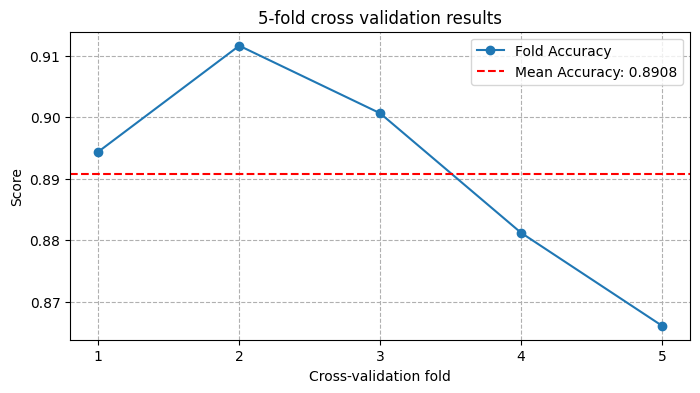

In [24]:
mean_accuracy = np.mean(accuracy_scores)

plt.figure(figsize=(8, 4))

plt.plot(range(1, num_folds + 1),
         accuracy_scores,
         marker='o',
         linestyle='-',
         label='Fold Accuracy'
         )
plt.axhline(y=mean_accuracy,
            color="r",
            linestyle="--",
            label=f"Mean Accuracy: {mean_accuracy:.4f}"
            )
plt.title("5-fold cross validation results")
plt.xlabel('Cross-validation fold')
plt.ylabel('Score')
plt.xticks(range(1, num_folds + 1))
plt.grid(True, linestyle="--")
plt.legend()
plt.show()

### 4 Model training

In [25]:
lstm = LSTM(emb_dim=100)
lstm.embeddings.from_pretrained(emb_matrix, freeze=False)
lstm = lstm.cuda()

history = utils.train(model=lstm,
              loss=nn.CrossEntropyLoss(),
              val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
              optimizer=torch.optim.Adam(lstm.parameters(), lr=5e-4),
              train_ds=train_iter,
              dev_ds=dev_iter,
              num_epochs=20,
              early_stopper=utils.EarlyStopper(metric_name="cls", patience=3),
              l2_regularization=utils.L2Regularization(l2_lambda=1e-4),
              max_grad_norm=4.0
              )

epoch 1 train loss: 0.8143 val_cls: 0.6824 val_acc: 0.5302
tensor(0.6824) None
epoch 2 train loss: 0.8034 val_cls: 0.6787 val_acc: 0.5690
tensor(0.6787) tensor(0.6824)
epoch 3 train loss: 0.7897 val_cls: 0.6722 val_acc: 0.5647
tensor(0.6722) tensor(0.6787)
epoch 4 train loss: 0.7342 val_cls: 0.5617 val_acc: 0.7155
tensor(0.5617) tensor(0.6722)
epoch 5 train loss: 0.5723 val_cls: 0.4327 val_acc: 0.8060
tensor(0.4327) tensor(0.5617)
epoch 6 train loss: 0.4759 val_cls: 0.3815 val_acc: 0.8793
tensor(0.3815) tensor(0.4327)
epoch 7 train loss: 0.3868 val_cls: 0.3601 val_acc: 0.8707
tensor(0.3601) tensor(0.3815)
epoch 8 train loss: 0.3159 val_cls: 0.3302 val_acc: 0.8621
tensor(0.3302) tensor(0.3601)
epoch 9 train loss: 0.2774 val_cls: 0.3353 val_acc: 0.8578
tensor(0.3353) tensor(0.3302)
epoch 10 train loss: 0.2599 val_cls: 0.2928 val_acc: 0.8664
tensor(0.2928) tensor(0.3302)
epoch 11 train loss: 0.2151 val_cls: 0.2832 val_acc: 0.8966
tensor(0.2832) tensor(0.2928)
epoch 12 train loss: 0.1840 v

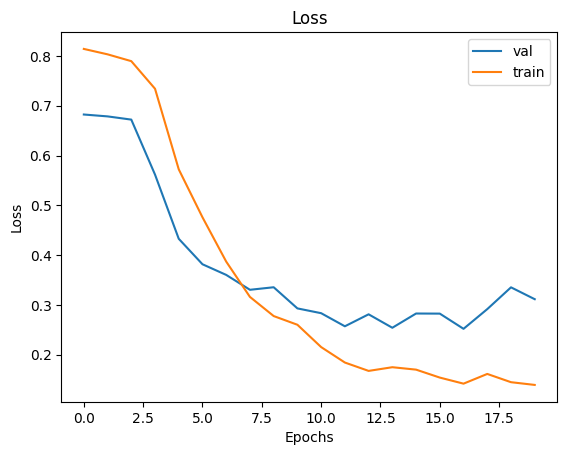

In [26]:
plt.plot(history["val_cls"], label="val")
plt.plot(history["train_loss"], label="train")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.82      0.94      0.88        95
           1       0.95      0.86      0.90       137

    accuracy                           0.89       232
   macro avg       0.89      0.90      0.89       232
weighted avg       0.90      0.89      0.89       232



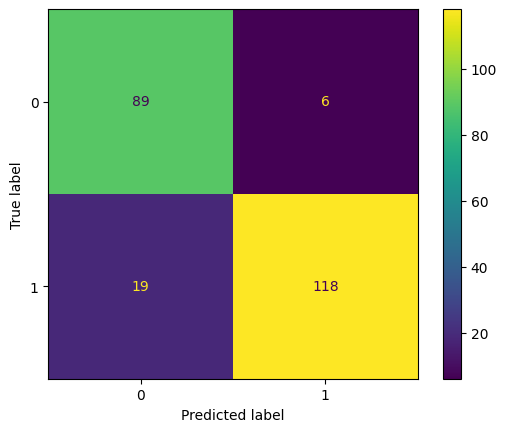

In [27]:
pred = utils.test(lstm, test_iter)
pred = np.argmax(pred, axis=1)

print(classification_report(y_pred=pred, y_true=y_test))
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=pred);

The performance is exactly as the cross validation predicted. But what if we add weight balancing to account for the class imbalance?

#### 4.1 Model training using balanced weights

In [23]:
class_weights = nn.CrossEntropyLoss(weight=c_weights.to(device))

In [24]:
lstm = LSTM(emb_dim=100)
lstm.embeddings.from_pretrained(emb_matrix, freeze=False)
lstm = lstm.cuda()

history = utils.train(model=lstm,
              loss=class_weights,
              val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
              optimizer=torch.optim.Adam(lstm.parameters(), lr=5e-4),
              train_ds=train_iter,
              dev_ds=dev_iter,
              num_epochs=20,
              early_stopper=utils.EarlyStopper(metric_name="cls", patience=3),
              l2_regularization=utils.L2Regularization(l2_lambda=1e-4),
              max_grad_norm=4.0
              )

epoch 1 train loss: 0.8297 val_cls: 0.6907 val_acc: 0.4741
tensor(0.6907) None
epoch 2 train loss: 0.8168 val_cls: 0.6864 val_acc: 0.5086
tensor(0.6864) tensor(0.6907)
epoch 3 train loss: 0.7895 val_cls: 0.6765 val_acc: 0.5862
tensor(0.6765) tensor(0.6864)
epoch 4 train loss: 0.6638 val_cls: 0.5312 val_acc: 0.7716
tensor(0.5312) tensor(0.6765)
epoch 5 train loss: 0.4957 val_cls: 0.4494 val_acc: 0.8147
tensor(0.4494) tensor(0.5312)
epoch 6 train loss: 0.4256 val_cls: 0.4013 val_acc: 0.8405
tensor(0.4013) tensor(0.4494)
epoch 7 train loss: 0.3249 val_cls: 0.3256 val_acc: 0.8922
tensor(0.3256) tensor(0.4013)
epoch 8 train loss: 0.2769 val_cls: 0.3111 val_acc: 0.8922
tensor(0.3111) tensor(0.3256)
epoch 9 train loss: 0.2336 val_cls: 0.3033 val_acc: 0.9052
tensor(0.3033) tensor(0.3111)
epoch 10 train loss: 0.1914 val_cls: 0.3192 val_acc: 0.8793
tensor(0.3192) tensor(0.3033)
epoch 11 train loss: 0.1841 val_cls: 0.3305 val_acc: 0.8966
tensor(0.3305) tensor(0.3033)
epoch 12 train loss: 0.1796 v

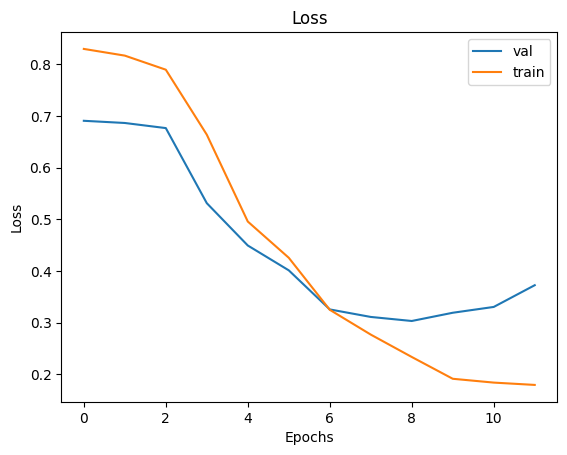

In [25]:
plt.plot(history["val_cls"], label="val")
plt.plot(history["train_loss"], label="train")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.88      0.92      0.90        95
           1       0.94      0.91      0.93       137

    accuracy                           0.91       232
   macro avg       0.91      0.91      0.91       232
weighted avg       0.91      0.91      0.91       232



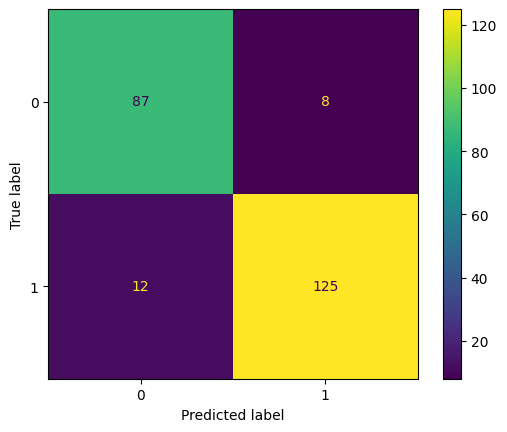

In [26]:
pred = utils.test(lstm, test_iter)
pred = np.argmax(pred, axis=1)

print(classification_report(y_pred=pred, y_true=y_test))
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=pred);

### 5 Error analysis

In [27]:
results_lstm = pd.DataFrame({"hist_text_classic": X_test,
                            "true_label": y_test,
                            "predicted_label": pred,
                            "result": ["Correct" if true == pred else "Incorrect" for true, pred in zip(y_test, pred)],
                            "n_words": [len(text.split()) for text in X_test]
                            })

results_lstm.true_label.replace({0: "DC Comics", 1: "Marvel Comics"}, inplace=True)
results_lstm.predicted_label.replace({0: "DC Comics", 1: "Marvel Comics"}, inplace=True)

In [28]:
results_lstm.to_csv("data/error_lstm.csv",
                    index=False)

In [29]:
results_lstm[results_lstm["result"]=="Incorrect"]

,hist_text_classic,true_label,predicted_label,result,n_words
1238,max save magda gas chamber execution ; member ...,Marvel Comics,DC Comics,Incorrect,269
494,vic stone son pair scientist decide use test s...,DC Comics,Marvel Comics,Incorrect,245
302,"channel positive energy , blackwulf able slice...",Marvel Comics,DC Comics,Incorrect,210
1175,sam stern little slow - witte laborer complete...,Marvel Comics,DC Comics,Incorrect,135
2296,darren cross protégé hank pym usurp mentor ceo...,Marvel Comics,DC Comics,Incorrect,69
2071,mary macpherran bear prematurely suburb denver...,Marvel Comics,DC Comics,Incorrect,131
460,coolen wing bear hokkaido live mother.however ...,Marvel Comics,DC Comics,Incorrect,27
1048,billy russo son meth addict . abandon birth mo...,Marvel Comics,DC Comics,Incorrect,100
1201,lobo appear earth capture bounty red lantern a...,DC Comics,Marvel Comics,Incorrect,164
1315,mera undersea queen alien otherworldly dimensi...,DC Comics,Marvel Comics,Incorrect,311
